### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [618]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation

example_matrix = np.array([[5.45, 11.14], [11.14, 1.42]])
#example_matrix = np.array([[18.45, 1.14], [1.14, 15.82]])
#example_matrix = np.array([[1.45, 5.14], [5.14, 7.82]])
#example_matrix = np.array([[13.45, 3.4], [3.4, 1.82]])

big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])
#example_matrix = np.array([[1.5, 0.5, 1.5, 0.4], [0.5, 2, 2.9, 1.5], [0.3,0.5, 2.5, 1.6], [0.5, 0.5, 0.5, 2.5]])
#example_matrix = np.array([[1.7, 0.2, 1.5, 0.2], [0.7, 1, 2.9, 1.1], [0.5,1.5, .7, 1.6], [0.5, 1.5, 0.5, 1.7]])
#example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix = np.array([[1.5, .5], [.5, 1.5]])
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.10611139 0.44334253 0.44334253 0.00720354]


In [619]:
eig,e_v=np.linalg.eig(example_matrix)
b=np.array([3.,1.])
#b=np.array([0,1,2,3])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)

(array([[2.17799143, 0.98403204],
        [0.98403204, 1.82200857]]),
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

In [620]:
example_matrix=BB

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.47436467 0.09683191 0.09683191 0.33197152]


In [621]:
example_matrix

array([[2.17799143, 0.98403204],
       [0.98403204, 1.82200857]])

In [622]:
np.linalg.eig(example_matrix)

(array([3., 1.]),
 array([[ 0.76746056, -0.64109616],
        [ 0.64109616,  0.76746056]]))

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [623]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, len(example_matrix)+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))

    #add root tree
    nodes.insert(0, 1)

    idx_sub=1
    thetas=[]
    for i in range(len(nodes)-len(input_probabilities)):
        right_node=i+idx_sub
        left_node=right_node+1
        #print(left_node,right_node)
        if nodes[i]!=0:
            #print(nodes[right_node],nodes[i])
            thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx_sub+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [624]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [625]:
thetas, all_combinations = thetas_computation(example_matrix)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.7557754778256228
1 -> 0.6548308385510349
00 -> 0.688741365010434
01 -> 0.31117825278465794
10 -> 0.3111782527846579
11 -> 0.5761696990569176


┌────────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(1.4279) ├┤ X ├───────■───────┤ X ├──────■───────
     └────────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(0.84871) ├─────┤ Ry(2.1512) ├
                        └─────────────┘     └────────────┘

In [626]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'00': 0.474364667876436,
 '01': 0.096831905006112,
 '10': 0.096831905006113,
 '11': 0.331971522111339}

In [627]:
#Unitary for PE
resolution = 2
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1514/4115894098.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))


Operator([[2.97102750e-16-0.17799143j, 7.53486851e-16-0.98403204j],
          [7.53486851e-16-0.98403204j, 2.45217798e-17+0.17799143j]],
         input_dims=(2,), output_dims=(2,))

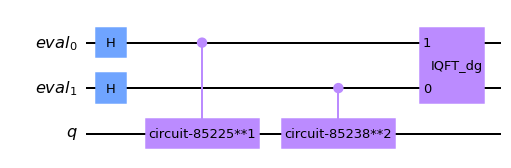

In [628]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

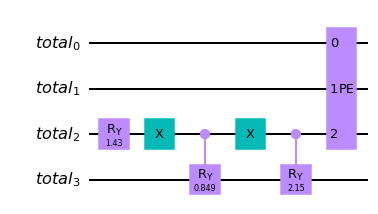

In [629]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

In [630]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [631]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [632]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
attach_bitstrings(statevector)

[('0000', (-0-0j)),
 ('0001', -0j),
 ('0010', (0.13-0j)),
 ('0011', (0.5588+0j)),
 ('0100', (-0-0j)),
 ('0101', -0j),
 ('0110', (-0.1556-0j)),
 ('0111', (0.4668+0j)),
 ('1000', (-0-0j)),
 ('1001', -0j),
 ('1010', (-0.1556-0j)),
 ('1011', (0.4668+0j)),
 ('1100', (-0-0j)),
 ('1101', -0j),
 ('1110', (0.1863+0j)),
 ('1111', (0.3899+0j))]

# Computing Probabilities

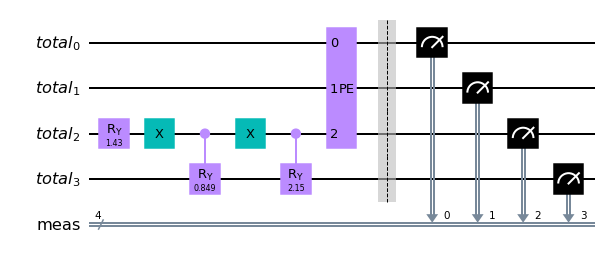

In [633]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_1 = QuantumCircuit(qr_total , name='matrix')

total_circuit_1.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_1.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit_1.swap(qr_total[0],qr_total[1])
total_circuit_1.measure_all()

total_circuit_1.decompose(reps=1).draw("mpl")

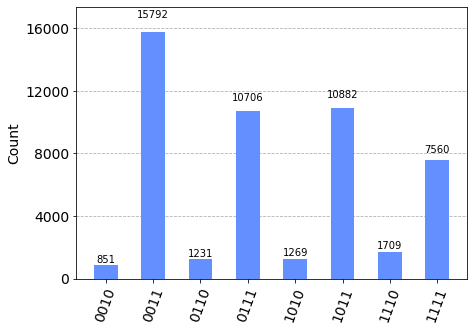

In [634]:
n_shots=50000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_1, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [635]:
for i in counts:
    counts[i]/=n_shots
counts

{'0110': 0.02462,
 '1010': 0.02538,
 '0010': 0.01702,
 '1110': 0.03418,
 '1011': 0.21764,
 '0111': 0.21412,
 '1111': 0.1512,
 '0011': 0.31584}

In [636]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
statevector

array([0.     , 0.     , 0.01702, 0.31584, 0.     , 0.     , 0.02462,
       0.21412, 0.     , 0.     , 0.02538, 0.21764, 0.     , 0.     ,
       0.03418, 0.1512 ])

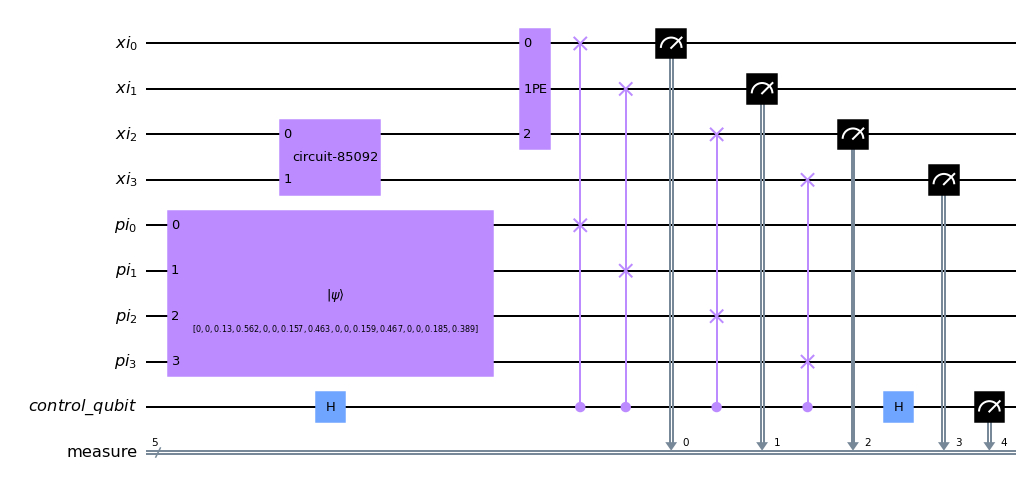

In [637]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[resolution:])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:pe.num_qubits])

#total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_2.h(qr_control)
for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

total_circuit_2.h(qr_control)
total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")

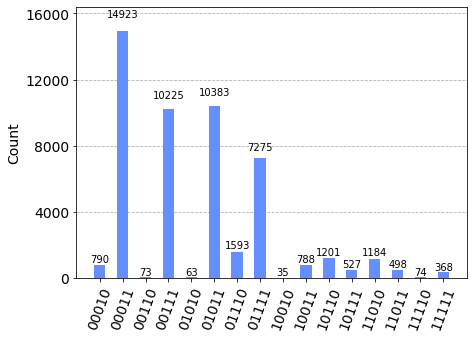

In [638]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [639]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
tmp

array([    0.,     0.,   790., 14923.,     0.,     0.,    73., 10225.,
           0.,     0.,    63., 10383.,     0.,     0.,  1593.,  7275.])

In [640]:
statevector

array([0.     , 0.     , 0.01702, 0.31584, 0.     , 0.     , 0.02462,
       0.21412, 0.     , 0.     , 0.02538, 0.21764, 0.     , 0.     ,
       0.03418, 0.1512 ])

In [641]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [642]:
sign_dictionary

{'0000': 0,
 '0001': 0,
 '0010': 1,
 '0011': 1,
 '0100': 0,
 '0101': 0,
 '0110': -1,
 '0111': 1,
 '1000': 0,
 '1001': 0,
 '1010': -1,
 '1011': 1,
 '1100': 0,
 '1101': 0,
 '1110': 1,
 '1111': 1}

In [643]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

statevector_dictionary

{'0000': 0.0,
 '0001': 0.0,
 '0010': 0.13046072205840348,
 '0011': 0.5619964412698714,
 '0100': 0.0,
 '0101': 0.0,
 '0110': -0.15690761613127643,
 '0111': 0.46273102338183464,
 '1000': 0.0,
 '1001': 0.0,
 '1010': -0.15931101656822105,
 '1011': 0.4665190242637485,
 '1100': 0.0,
 '1101': 0.0,
 '1110': 0.18487833837418596,
 '1111': 0.3888444419044716}

# Eigenvectors reconstruction (2x2 matrix)


In [644]:
binary_lambda=[]
for d in statevector_dictionary:
    if statevector_dictionary[d]!=0:
        binary_lambda.append(d[-resolution:])
l_list=[]
eigenvalues=[]
for b_l in np.unique(binary_lambda):
    eigenvalues.append(int(b_l[::-1],2))
    tmp_list=[]
    for key in list(statevector_dictionary.keys()):
        if key[-resolution:]==b_l:
            tmp_list.append(statevector_dictionary[key])
    l_list.append(np.asarray(tmp_list))
l_list

[array([ 0.13046072, -0.15690762, -0.15931102,  0.18487834]),
 array([0.56199644, 0.46273102, 0.46651902, 0.38884444])]

In [645]:
for l in l_list:
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor

In [646]:
l_list

[array([ 0.41009977, -0.49323487, -0.50078989,  0.58116008]),
 array([0.59279159, 0.48808683, 0.49208239, 0.41015156])]

In [647]:
#TODO: check sign 
eigenvectors=[]
for ll, eig in zip(l_list,eigenvalues):
    #print(ll,eig)
    eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    statevector=abs(ll)
    tmp_list=[]
    scale=min(statevector[:2]/max(statevector[:2])) ## Si potrebbe anche fare una media dei vari scaling visto che dipendono dall'approssimazione e non sono proprio tutti uguali
    #print(scale)
    #print(statevector)
    for i in range(0,len(statevector),2):
        maximum=statevector[i]
        if statevector[i+1]>maximum:
            maximum=statevector[i+1]
            tmp_list.append((1,maximum)) # the index 0 or 1 indicates the position in the eigenvector
        else:
            tmp_list.append((0,maximum))
        #print(tmp_list)
        
    idx,v1=max(tmp_list)
    #print(save_sign[abs(idx-1)])
    v1=np.sqrt(v1)
    #eigenvector[idx],eigenvector[abs(idx-1)]=v1*save_sign[idx],v1*scale*save_sign[abs(idx-1)]
    eigenvector[idx],eigenvector[abs(idx-1)]=v1*save_sign[abs(idx-1)],v1*scale*save_sign[idx]
    '''if save_sign[1]!=save_sign[2]:
        eigenvector[idx],eigenvector[abs(idx-1)]=v1*save_sign[abs(idx-1)],v1*scale*save_sign[idx]
    else:
        eigenvector[idx],eigenvector[abs(idx-1)]=v1*save_sign[idx],v1*scale*save_sign[abs(idx-1)]'''
        
    eigenvectors.append(eigenvector)
    print('reconstructed eigenvector: ', eigenvector)
    print('eigenvalue:', eig)
    print('\n')

reconstructed eigenvector:  [-0.63384583  0.76233856]
eigenvalue: 1


reconstructed eigenvector:  [0.7699296  0.63393695]
eigenvalue: 3




In [648]:
np.linalg.eig(example_matrix)

(array([3., 1.]),
 array([[ 0.76746056, -0.64109616],
        [ 0.64109616,  0.76746056]]))

# 4x4 matrix

$$\left|00\right\rangle(0.1133|0000\rangle+0.23|0001\rangle+0.18|0010\rangle+0.12|0011\rangle+
0.24|0100\rangle+0.50|0101\rangle+0.39|0110\rangle+0.27|0111\rangle+
0.17|1000\rangle+0.35|1001\rangle+0.27|1010\rangle+0.18|1011\rangle+
0.08|1100\rangle+0.16|1101\rangle+0.14|1110\rangle+0.09|1111\rangle) =$$

$$\left|00\right\rangle\left[\textbf{0.23|00}\rangle(0.47|00\rangle+|01\rangle+0.78|10\rangle+
0.52|11\rangle)+\textbf{0.50|01}\rangle(0.48|00\rangle+|01\rangle+0.78|10\rangle+
0.54|11\rangle)+\textbf{0.35|10}\rangle(0.48|00\rangle+|01\rangle+0.77|10\rangle+
0.5|11\rangle)+\textbf{0.16|00}\rangle(0.5|00\rangle+|01\rangle+0.8|10\rangle+
0.5|11\rangle)\right]=$$

$$\left|00\right\rangle\left[(0.23|00\rangle+0.50|01\rangle+0.35|10\rangle+
0.16|11\rangle)(0.48|00\rangle+|01\rangle+0.7|10\rangle+
0.5|11\rangle)\right]=$$


$$\left|00\right\rangle\left[\textbf{0.50|0}\rangle(0.46|0\rangle+|1\rangle)+\textbf{0.35|1}\rangle(|0\rangle+0.46|1\rangle)(0.48|00\rangle+|01\rangle+0.7|10\rangle+
0.5|11\rangle)\right]=$$

## 1st matrix_example

In [501]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.4063074844837685,
  '0101': -0.4947759382402847,
  '1001': -0.48985675123506794,
  '1101': 0.5917358889406178},
 {'0011': 0.5898840122966107,
  '0111': 0.49452547412185405,
  '1011': 0.4915537016695547,
  '1111': 0.4072546695329175},
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

$$\left|01\right\rangle(0.4063|00\rangle-0.4947|01\rangle-0.4898|10\rangle+0.5917|11\rangle) =$$

$$\left|01\right\rangle(0.4947|0\rangle(0.8213|0\rangle-|1\rangle)-0.5917|1\rangle(0.8277|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.4947|0\rangle-0.5917|1\rangle)(0.82|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.5917(0.8360|0\rangle-|1\rangle)(0.82|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.5917}=0.7692$$

$$0.7692*\approx0.8*\text{sign}\left|1\right\rangle=-0.6153$$




$$\left|11\right\rangle(0.5898|00\rangle+0.4945|01\rangle+0.4915|10\rangle+0.4072|11\rangle) =$$

$$\left|11\right\rangle(0.5898|0\rangle(|0\rangle+0.83|1\rangle)+0.4915|1\rangle(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle((0.5898|0\rangle+0.4915|1\rangle)(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle(0.5898(|0\rangle+0.83|1\rangle)(|0\rangle+0.83|1\rangle)) =>$$

$$\sqrt{0.5898}=0.7679$$

$$0.7679*\approx0.8*\text{sign}\left|0\right\rangle=0.6143$$




## 2nd matrix_example

$$\left|01\right\rangle(0.1272|00\rangle-0.3143|01\rangle-0.3203|10\rangle+0.8845|11\rangle) =$$

$$\left|01\right\rangle(0.3143|0\rangle(0.40|0\rangle-|1\rangle)-0.8845|1\rangle(0.36|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.3143|0\rangle-0.8845|1\rangle)(0.4|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.8845(0.36|0\rangle-|1\rangle)(0.4|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.8845}=0.9404$$

$$0.9404*\approx0.4*\text{sign}\left|1\right\rangle=-0.3761$$




## 3d matrix_example

In [643]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.36710092124099825,
  '0101': 0.6614992335357107,
  '1001': 0.3149078628268718,
  '1101': 0.5731393509308969},
 {'0011': 0.8721533545579773,
  '0111': -0.4889160360072559,
  '1011': 0.013630169512202875,
  '1111': -0.011128986804178979},
 (array([3., 1.]),
  array([[ 0.87370608,  0.4864542 ],
         [-0.4864542 ,  0.87370608]])))

$$\left|01\right\rangle(0.3671|00\rangle+0.6614|01\rangle+0.3149|10\rangle+0.5731|11\rangle) =$$

$$\left|01\right\rangle(0.6614|0\rangle(0.55|0\rangle+|1\rangle)+0.5731|1\rangle(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle((0.6614|0\rangle+0.5731|1\rangle)(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle(0.6614(|0\rangle+\approx0.8|1\rangle)(0.55|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.6614}=\approx0.81$$

$$0.81*\approx0.55*\text{sign}\left|1\right\rangle=\approx0.44$$




$$\left|11\right\rangle(0.8721|00\rangle-0.4889|01\rangle+0.0136|10\rangle-0.0111|11\rangle) =$$

$$\left|11\right\rangle(0.8721|0\rangle(|0\rangle-\approx0.5|1\rangle)+0.0136|1\rangle(|0\rangle-\approx0.8|1\rangle)) =$$

$$\left|11\right\rangle((0.8721|0\rangle+0.0136|1\rangle)(|0\rangle-\approx0.5|1\rangle)) =$$

$$\left|11\right\rangle(0.8721(|0\rangle+0.0155|1\rangle)(|0\rangle-0.5|1\rangle)) =>$$

$$\sqrt{0.8721}=\approx0.93$$

$$0.93*\approx0.5*\text{sign}\left|0\right\rangle=\approx0.44$$




## 4th matrix_example

In [672]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.06844207564752064,
  '0101': -0.2434477406836873,
  '1001': -0.26237207143606917,
  '1101': 0.9312409870529826},
 {'0011': 0.9317470599478411,
  '0111': 0.2529050552183149,
  '1011': 0.251498062074687,
  '1111': 0.06808211289503242},
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

$$\left|11\right\rangle(0.93|00\rangle+0.25|01\rangle+0.25|10\rangle+0.068|11\rangle) =$$

$$\left|11\right\rangle(0.93|0\rangle(|0\rangle+\approx0.26|1\rangle)+0.25|1\rangle(|0\rangle+0.2|1\rangle)) =$$

$$\left|11\right\rangle((0.93|0\rangle+0.25|1\rangle)(|0\rangle+\approx0.2|1\rangle)) =$$

$$\left|11\right\rangle(0.93(|0\rangle+0.2|1\rangle)(|0\rangle+0.2|1\rangle)) =>$$

$$\sqrt{0.93}=\approx0.96$$

$$0.96*\approx0.2*\text{sign}\left|0\right\rangle=\approx0.25$$


